# Import

In [87]:
import koreanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# Call train data

In [9]:
df = pd.read_csv('train_data_1.csv', encoding = 'utf-8')

In [10]:
df.head()

,prod,insp,wtcd,origin,ingr_C,ingr_extra,A_P,extra_P,duration,date_month,label
0,GBMD,C,F3,산천,6.9409,557.5693,0.411623,0.574624,92,6,1
1,GGMD,L,F1,창하,6.2857,2347.8747,0.052245,0.942891,51,5,0
2,KCMD,C,F3,창하,6.0607,343.9861,0.269855,0.705801,58,5,0
3,GBMD,K,F3,산천,6.1705,566.2997,0.181651,0.799926,30,5,1
4,JJBB,K,F3,수성,6.3695,1645.8516,0.162075,0.831801,5,4,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9989 entries, 0 to 9988
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prod        9989 non-null   object 
 1   insp        9989 non-null   object 
 2   wtcd        9989 non-null   object 
 3   origin      9989 non-null   object 
 4   ingr_C      9989 non-null   float64
 5   ingr_extra  9989 non-null   float64
 6   A_P         9989 non-null   float64
 7   extra_P     9989 non-null   float64
 8   duration    9989 non-null   int64  
 9   date_month  9989 non-null   int64  
 10  label       9989 non-null   int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 858.6+ KB


# Preprocess dataset to be suitable for train

### One-hot encoding : 'prod', 'insp', 'wtcd', 'origin'

In [12]:
# Initialize OneHotEncoder and perform encoding
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(df[['prod', 'insp', 'wtcd', 'origin']])

# Convert the encoded data into a DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['prod', 'insp', 'wtcd', 'origin']))

# Drop the original 'prod', 'insp', 'wtcd', and 'origin' columns
df = df.drop(['prod', 'insp', 'wtcd', 'origin'], axis = 1)

# Concatenate the original DataFrame with the encoded DataFrame
df = pd.concat([df, encoded_df], axis=1)

In [13]:
df.head()

,ingr_C,ingr_extra,A_P,extra_P,duration,date_month,label,prod_GBMD,prod_GGMD,prod_JJBB,...,insp_L,insp_P,insp_Y,wtcd_F1,wtcd_F2,wtcd_F3,origin_산천,origin_수성,origin_오포,origin_창하
0,6.9409,557.5693,0.411623,0.574624,92,6,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,6.2857,2347.8747,0.052245,0.942891,51,5,0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,6.0607,343.9861,0.269855,0.705801,58,5,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,6.1705,566.2997,0.181651,0.799926,30,5,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,6.3695,1645.8516,0.162075,0.831801,5,4,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


### Split dataset into X/Y and train/validation dataset

In [14]:
train_set, validation_set = train_test_split(df, test_size = 0.3, random_state = 7)

# Separate features and target variable from train_set DataFrame
x_train = train_set.drop('label', axis=1)  # Use all columns except 'label' as feature data
y_train = train_set['label']  # Use 'label' column as the target variable

# Separate features and target variable from validation_set DataFrame
x_val = validation_set.drop('label', axis = 1)
y_val = validation_set['label']

### Training dataset for cross validation

In [15]:
x_train_cv = df.drop('label', axis = 1)
y_train_cv = df['label']

# PCA

### 3 dimension

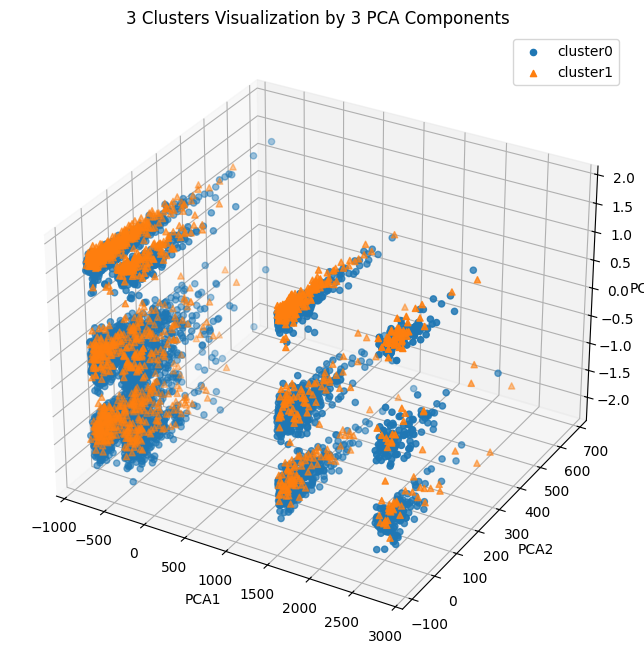

In [19]:
# Perform PCA (3 main components)
pca = PCA(n_components=3)
pca_transformed = pca.fit_transform(train_set)

# Set 3D coordinates
train_set['pca_x'] = pca_transformed[:, 0]
train_set['pca_y'] = pca_transformed[:, 1]
train_set['pca_z'] = pca_transformed[:, 2]

# Set indices by label
marker0 = train_set[train_set['label'] == 0].index
marker1 = train_set[train_set['label'] == 1].index

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot by label
ax.scatter(train_set.loc[marker0, 'pca_x'], train_set.loc[marker0, 'pca_y'], train_set.loc[marker0, 'pca_z'], marker='o')
ax.scatter(train_set.loc[marker1, 'pca_x'], train_set.loc[marker1, 'pca_y'], train_set.loc[marker1, 'pca_z'], marker='^')

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title('3 Clusters Visualization by 3 PCA Components')
plt.legend(['cluster0', 'cluster1'])
plt.show()

### 4 dimension

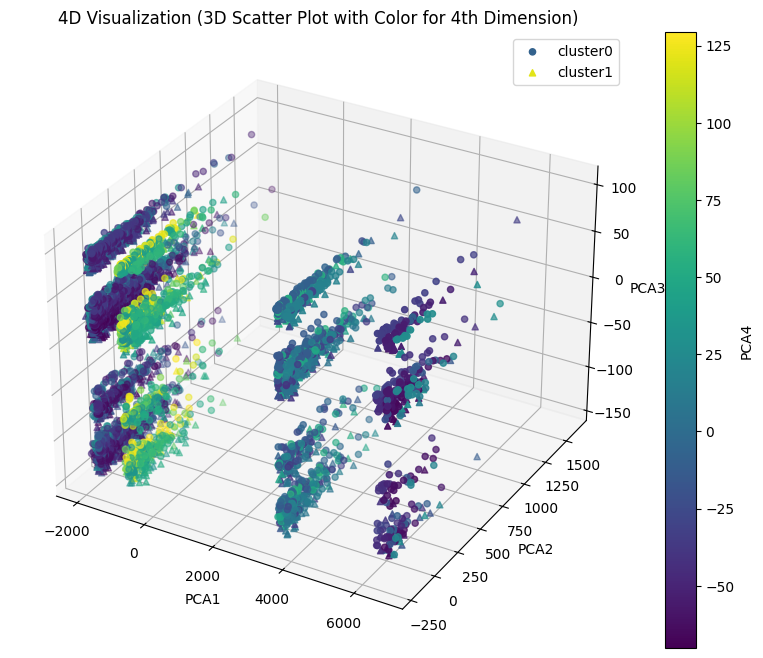

In [33]:
# Perform PCA (4 main components)
pca = PCA(n_components=4)
pca_transformed = pca.fit_transform(train_set)

# Set 4D coordinates
train_set['pca_x'] = pca_transformed[:, 0]
train_set['pca_y'] = pca_transformed[:, 1]
train_set['pca_z'] = pca_transformed[:, 2]
train_set['pca_color'] = pca_transformed[:, 3]  # Use 4th component for color mapping

# Set indices by label
marker0 = train_set[train_set['label'] == 0].index
marker1 = train_set[train_set['label'] == 1].index

# Create 3D scatter plot with color representing the 4th dimension
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for label 0 and 1
sc0 = ax.scatter(train_set.loc[marker0, 'pca_x'], train_set.loc[marker0, 'pca_y'], train_set.loc[marker0, 'pca_z'],
                 c=train_set.loc[marker0, 'pca_color'], cmap='viridis', marker='o', label='cluster0')
sc1 = ax.scatter(train_set.loc[marker1, 'pca_x'], train_set.loc[marker1, 'pca_y'], train_set.loc[marker1, 'pca_z'],
                 c=train_set.loc[marker1, 'pca_color'], cmap='viridis', marker='^', label='cluster1')

# Add color bar for the 4th PCA component
cbar = fig.colorbar(sc0, ax=ax)
cbar.set_label('PCA4')

# Set axis labels and title
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title('4D Visualization (3D Scatter Plot with Color for 4th Dimension)')
plt.legend()
plt.show()


### 5 dimension

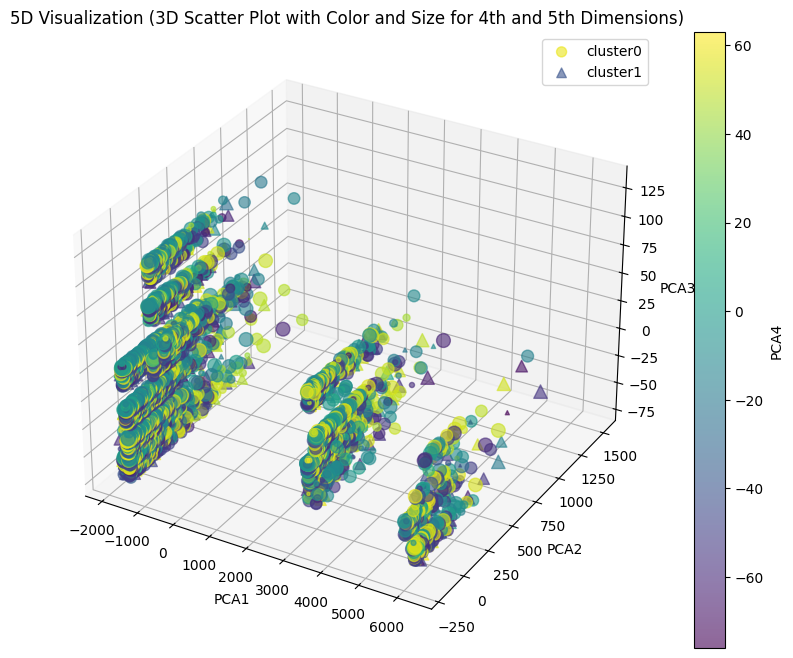

In [31]:
# Perform PCA (5 main components)
pca = PCA(n_components=5)
pca_transformed = pca.fit_transform(train_set)

# Set 5D coordinates
train_set['pca_x'] = pca_transformed[:, 0]
train_set['pca_y'] = pca_transformed[:, 1]
train_set['pca_z'] = pca_transformed[:, 2]
train_set['pca_color'] = pca_transformed[:, 3]  # 4th PCA component for color mapping
train_set['pca_size'] = pca_transformed[:, 4]   # 5th PCA component for size mapping

# Normalize the size for better visualization
train_set['pca_size_normalized'] = (train_set['pca_size'] - train_set['pca_size'].min()) / (train_set['pca_size'].max() - train_set['pca_size'].min()) * 100

# Set indices by label
marker0 = train_set[train_set['label'] == 0].index
marker1 = train_set[train_set['label'] == 1].index

# Create 3D scatter plot with color and size representing the 4th and 5th dimensions
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for label 0
sc0 = ax.scatter(train_set.loc[marker0, 'pca_x'], train_set.loc[marker0, 'pca_y'], train_set.loc[marker0, 'pca_z'],
                 c=train_set.loc[marker0, 'pca_color'], s=train_set.loc[marker0, 'pca_size_normalized'],
                 cmap='viridis', marker='o', label='cluster0', alpha=0.6)

# Scatter plot for label 1
sc1 = ax.scatter(train_set.loc[marker1, 'pca_x'], train_set.loc[marker1, 'pca_y'], train_set.loc[marker1, 'pca_z'],
                 c=train_set.loc[marker1, 'pca_color'], s=train_set.loc[marker1, 'pca_size_normalized'],
                 cmap='viridis', marker='^', label='cluster1', alpha=0.6)

# Add color bar for the 4th PCA component
cbar = fig.colorbar(sc0, ax=ax)
cbar.set_label('PCA4')

# Set axis labels and title
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title('5D Visualization (3D Scatter Plot with Color and Size for 4th and 5th Dimensions)')
plt.legend()
plt.show()


##### The fact that PCA clusters are mixed, it can imply 2 things
- Data cannot be linearly divided
- It might be better represented in higher dimensions
- Feature engineering must be done more meticulously

# T-SNE

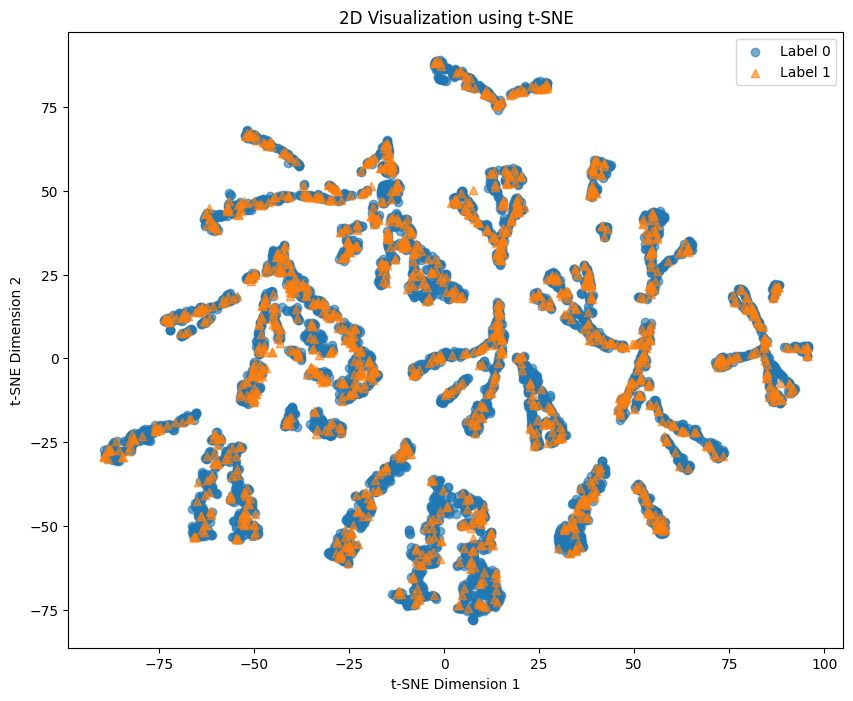

In [36]:
# Initialize t-SNE model (reduce to 2 dimensions)
tsne = TSNE(n_components=2, random_state=42)

# Apply t-SNE to the data (using features excluding 'label')
tsne_transformed = tsne.fit_transform(train_set.drop('label', axis=1))

# Convert t-SNE results into a DataFrame
train_set['tsne_x'] = tsne_transformed[:, 0]
train_set['tsne_y'] = tsne_transformed[:, 1]

# Visualize 2D scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(train_set[train_set['label'] == 0]['tsne_x'], train_set[train_set['label'] == 0]['tsne_y'], label='Label 0', marker='o', alpha=0.6)
plt.scatter(train_set[train_set['label'] == 1]['tsne_x'], train_set[train_set['label'] == 1]['tsne_y'], label='Label 1', marker='^', alpha=0.6)
plt.title('2D Visualization using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()


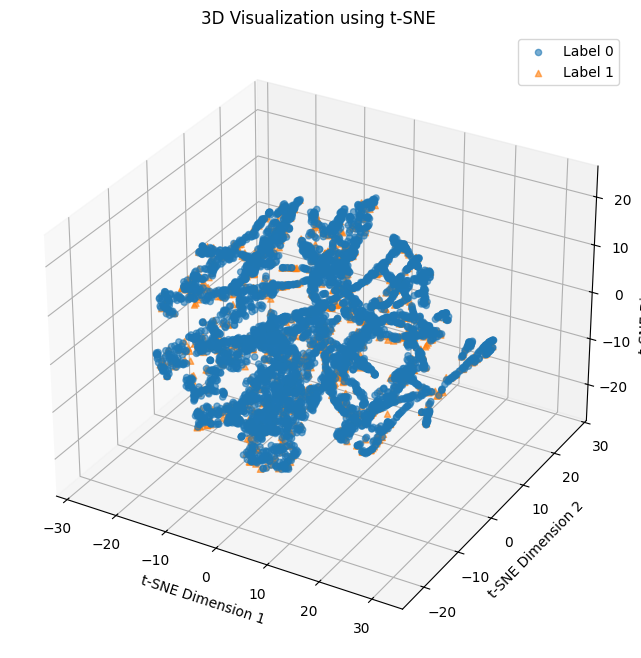

In [37]:
# Initialize t-SNE model (reduce to 3 dimensions)
tsne = TSNE(n_components=3, random_state=42)

# Apply t-SNE to the data (using features excluding 'label')
tsne_transformed = tsne.fit_transform(train_set.drop('label', axis=1))

# Convert t-SNE results into a DataFrame
train_set['tsne_x'] = tsne_transformed[:, 0]
train_set['tsne_y'] = tsne_transformed[:, 1]
train_set['tsne_z'] = tsne_transformed[:, 2]

# Visualize 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot t-SNE results
ax.scatter(train_set[train_set['label'] == 0]['tsne_x'], train_set[train_set['label'] == 0]['tsne_y'], train_set[train_set['label'] == 0]['tsne_z'], marker='o', label='Label 0', alpha=0.6)
ax.scatter(train_set[train_set['label'] == 1]['tsne_x'], train_set[train_set['label'] == 1]['tsne_y'], train_set[train_set['label'] == 1]['tsne_z'], marker='^', label='Label 1', alpha=0.6)
ax.set_title('3D Visualization using t-SNE')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.legend()
plt.show()


# Machine Learning Process

## Decision Tree

##### criterion : gini

In [49]:
# Create Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=98, criterion='gini')

# Perform cross-validation + calculate prediction probabilities for each fold
y_prob = cross_val_predict(decision_tree, x_train_cv, y_train_cv, cv=5, method='predict_proba')

# Extract the probabilities for class 1
y_probs_positive = y_prob[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_train_cv, y_probs_positive)

print("Cross-Validation AUC: ", auc_score)

Cross-Validation AUC:  0.5213997038959636


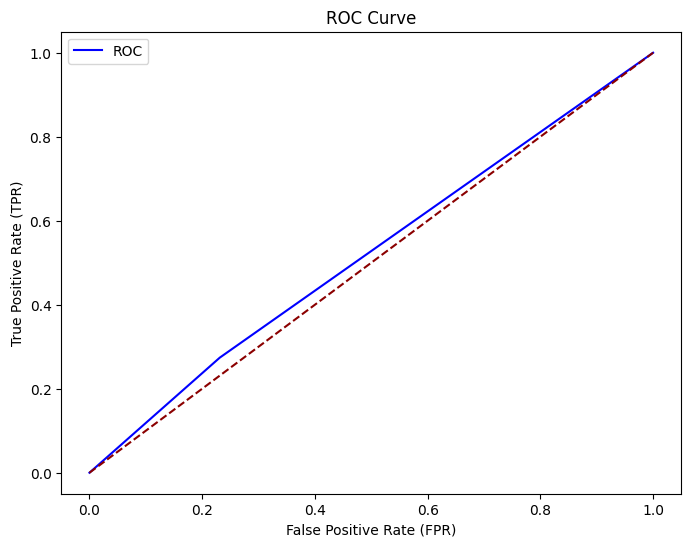

In [50]:
fpr, tpr, thresholds = roc_curve(y_train_cv, y_probs_positive)

# ROC 커브 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC')
plt.plot([0, 1], [0, 1], color='darkred', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

##### criterion : entropy

In [51]:
# Create Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=98, criterion='entropy')

# Perform cross-validation + calculate prediction probabilities for each fold
y_prob = cross_val_predict(decision_tree, x_train_cv, y_train_cv, cv=5, method='predict_proba')

# Extract the probabilities for class 1
y_probs_positive = y_prob[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_train_cv, y_probs_positive)

print("Cross-Validation AUC: ", auc_score)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Cross-Validation AUC:  0.5370272649467581


###### ROC curve 

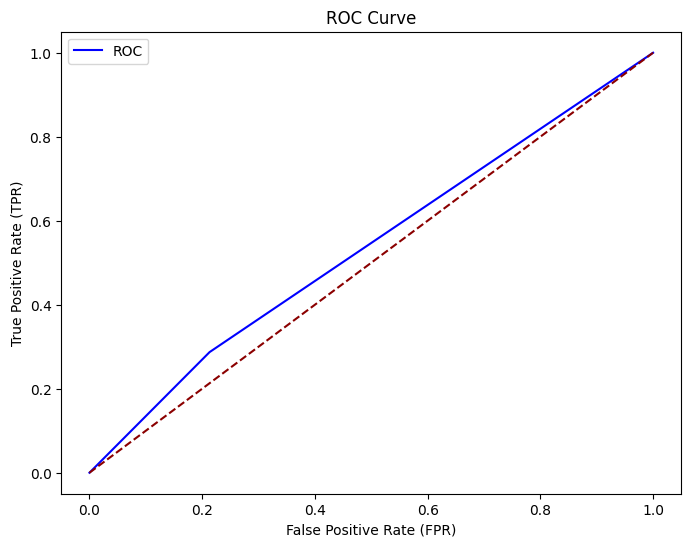

In [54]:
fpr, tpr, thresholds = roc_curve(y_train_cv, y_probs_positive)

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC')
plt.plot([0, 1], [0, 1], color='darkred', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

###### TPR, FNR

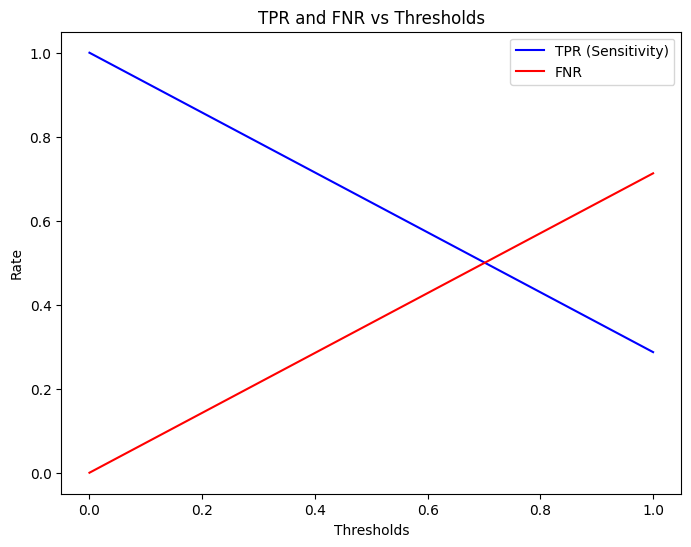

In [53]:
# Calculate FNR (FNR = 1 - TPR)
fnr = 1 - tpr

# Plot TPR and FNR
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, color='blue', label='TPR (Sensitivity)')
plt.plot(thresholds, fnr, color='red', label='FNR')
plt.xlabel('Thresholds')
plt.ylabel('Rate')
plt.title('TPR and FNR vs Thresholds')
plt.legend()
plt.show()

###### Feature importance

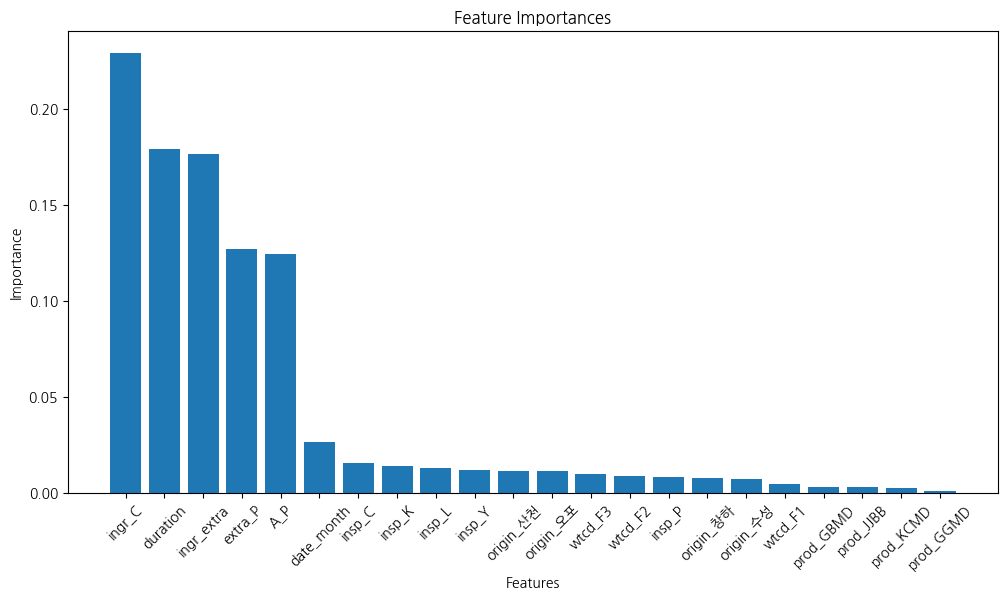

In [57]:
# Fit the decision tree model
decision_tree.fit(x_train_cv, y_train_cv)

# Get feature importances
feature_importances = decision_tree.feature_importances_

# Convert feature names and importances into a DataFrame
feature_importances_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})

# Sort features by importance
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Plot the top features by importance
plt.figure(figsize=(12, 6))
plt.bar(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.title('Feature Importances')
plt.show()

##### Result
- Decision Tree using entropy as criterion shows better performance

## Random Forest

In [65]:
# Create Random Forest model
random_forest = RandomForestClassifier(criterion='entropy', min_samples_leaf=1, oob_score=True, random_state=98, n_jobs=-1)

# Perform cross-validation + calculate prediction probabilities for each fold
y_probs_rf = cross_val_predict(random_forest, x_train_cv, y_train_cv, cv=5, method='predict_proba')

# Extract the predicted probabilities for the positive class
y_probs_positive_rf = y_probs_rf[:, 1]

# Calculate AUC score
auc_score_rf = roc_auc_score(y_train_cv, y_probs_positive_rf)
print("Random Forest Cross-Validation AUC: ", auc_score_rf)

Random Forest Cross-Validation AUC:  0.6174669310136731


#### Hyperparameter tuning

In [66]:
# Hyperparameter tuning

# Set up Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=98)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Set up Grid Search with AUC score for evaluation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

# Perform Grid Search
grid_search = grid_search.fit(x_train_cv, y_train_cv)

# Print the best hyperparameters and the corresponding AUC score
print("Best parameters:", grid_search.best_params_)
print("Best AUC score:", grid_search.best_score_)

/Users/ryoonki/opt/anaconda3/envs/defect_detection/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
515 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ryoonki/opt/anaconda3/envs/defect_detection/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ryoonki/opt/anaconda3/envs/defect_detection/lib/python3.9/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/ryoonki/opt/anaconda3/envs/defect_detection/lib/python3.9/s

Best parameters: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best AUC score: 0.6603793395034073


#### Best tuned Random Forest Model

In [75]:
rf_classifier_optimized = RandomForestClassifier(
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    random_state=98
)
# Perform cross-validation + calculate prediction probabilities for each fold
y_probs_rf = cross_val_predict(rf_classifier_optimized, x_train_cv, y_train_cv, cv=5, method='predict_proba')

# Extract the predicted probabilities for the positive class
y_probs_positive_rf = y_probs_rf[:, 1]

# Calculate AUC score
auc_score_rf = roc_auc_score(y_train_cv, y_probs_positive_rf)
print("Random Forest Cross-Validation AUC: ", auc_score_rf)

Random Forest Cross-Validation AUC:  0.6589684099040957


## Boosting

In [71]:
# Create XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=98)

# Calculate prediction probabilities through cross-validation
y_probs_xgb = cross_val_predict(xgb_model, x_train_cv, y_train_cv, cv=5, method='predict_proba')

# Extract the predicted probabilities for the positive class
y_probs_positive_xgb = y_probs_xgb[:, 1]

# Calculate AUC score
auc_score_xgb = roc_auc_score(y_train_cv, y_probs_positive_xgb)
print("XGBoost Cross-Validation AUC: ", auc_score_xgb)


XGBoost Cross-Validation AUC:  0.6003178729681554


#### Hyperparameter tuning

In [72]:
# Create XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=98)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.005, 0.01, 0.1, 0.2],
    # Additional hyperparameter combinations can be added here.
}

# Set up Grid Search with AUC score for evaluation
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

# Perform Grid Search
grid_search_xgb = grid_search_xgb.fit(x_train_cv, y_train_cv)

# Print the best hyperparameters and the corresponding AUC score
print("Best parameters:", grid_search_xgb.best_params_)
print("Best AUC score:", grid_search_xgb.best_score_)


Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best AUC score: 0.6632360333122916


In [73]:
xgb_model_optimized = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.01,
    random_state=98
)
# Perform cross-validation + calculate prediction probabilities for each fold
y_probs_rf = cross_val_predict(xgb_model_optimized, x_train_cv, y_train_cv, cv=5, method='predict_proba')

# Extract the predicted probabilities for the positive class
y_probs_positive_rf = y_probs_rf[:, 1]

# Calculate AUC score
auc_score_rf = roc_auc_score(y_train_cv, y_probs_positive_rf)
print("Random Forest Cross-Validation AUC: ", auc_score_rf)


Random Forest Cross-Validation AUC:  0.6620142559728361


## Blending

In [79]:
# Split the data into train/validation (for Blending)
x_train_part, x_blend_part, y_train_part, y_blend_part = train_test_split(x_train, y_train, test_size=0.3, random_state=7)

# Define base models
rf_model = RandomForestClassifier(
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    random_state=98
)
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.01,
    random_state=98
)

# Train the base models (on 70% of the train data)
rf_model.fit(x_train_part, y_train_part)
xgb_model.fit(x_train_part, y_train_part)

# Get the validation predictions from the base models (30% of the train data)
rf_probs = rf_model.predict_proba(x_blend_part)[:, 1]  # RandomForest predicted probabilities (positive class)
xgb_probs = xgb_model.predict_proba(x_blend_part)[:, 1]  # XGBoost predicted probabilities (positive class)

# Create features for the meta model using the predicted probabilities
blend_features = np.column_stack((rf_probs, xgb_probs))  # Combine the predicted probabilities from both models

# Define the meta model (Logistic Regression)
meta_model = LogisticRegression()

# Train the meta model (on the validation data)
meta_model.fit(blend_features, y_blend_part)

# Get predictions from the base models for the test/validation data
rf_test_probs = rf_model.predict_proba(x_val)[:, 1]
xgb_test_probs = xgb_model.predict_proba(x_val)[:, 1]

# Use the meta model to make the final prediction
val_blend_features = np.column_stack((rf_test_probs, xgb_test_probs))
y_pred_final = meta_model.predict_proba(val_blend_features)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_val, y_pred_final)
print("Blending AUC:", auc_score)

Blending AUC: 0.6775367814831905


## Stacking

In [93]:
# Define base models
rf_model = RandomForestClassifier(
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    random_state=98
)

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.01,
    random_state=98
)

# Define meta model (Logistic Regression)
meta_model = LogisticRegression()

# Set up KFold (for stacking cross-validation)
kf = KFold(n_splits=5, shuffle=True, random_state=98)

# Create arrays to store the predictions of the base models
train_blend_features = np.zeros((x_train.shape[0], 2))  # 2 base models, so 2 columns
test_blend_features = np.zeros((x_val.shape[0], 2))

# Train and predict with the base models using KFold cross-validation
for i, (train_index, val_index) in enumerate(kf.split(x_train)):
    x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train Random Forest model and predict
    rf_model.fit(x_train_fold, y_train_fold)
    train_blend_features[val_index, 0] = rf_model.predict_proba(x_val_fold)[:, 1]  # Store validation predictions
    test_blend_features[:, 0] += rf_model.predict_proba(x_val)[:, 1] / kf.n_splits  # Average test predictions

    # Train XGBoost model and predict
    xgb_model.fit(x_train_fold, y_train_fold)
    train_blend_features[val_index, 1] = xgb_model.predict_proba(x_val_fold)[:, 1]  # Store validation predictions
    test_blend_features[:, 1] += xgb_model.predict_proba(x_val)[:, 1] / kf.n_splits  # Average test predictions

# Train meta model (using the predictions from the base models)
meta_model.fit(train_blend_features, y_train)

# Perform final prediction with the meta model
y_pred_final = meta_model.predict_proba(test_blend_features)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_val, y_pred_final)
print("Stacking AUC:", auc_score)

Stacking AUC: 0.6881081914804117


#### Visualization

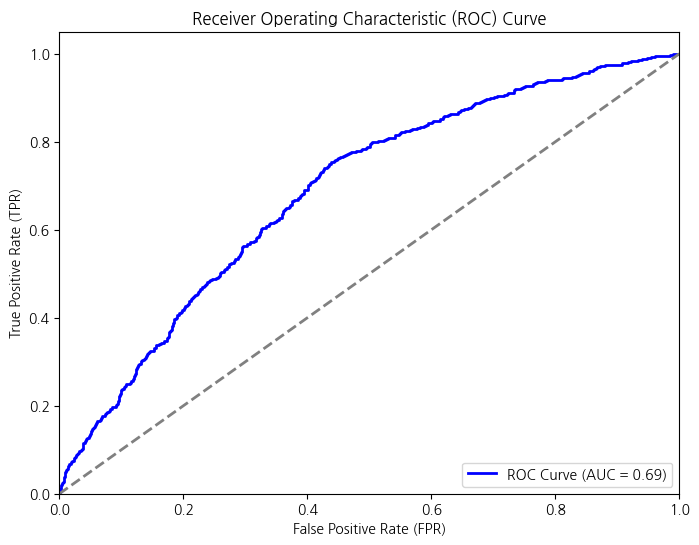

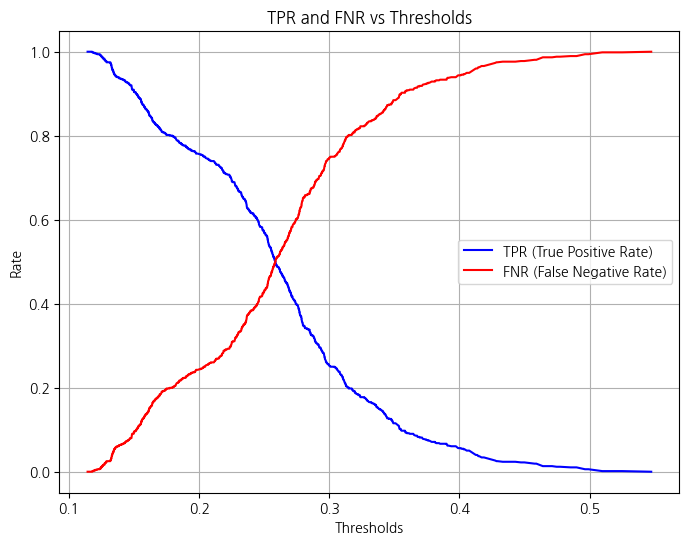

In [95]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_final)
roc_auc = auc(fpr, tpr)

# Visualize ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot TPR and FNR
fnr = 1 - tpr  # FNR = 1 - TPR

plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, color='blue', label='TPR (True Positive Rate)')
plt.plot(thresholds, fnr, color='red', label='FNR (False Negative Rate)')
plt.xlabel('Thresholds')
plt.ylabel('Rate')
plt.title('TPR and FNR vs Thresholds')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Test

### Test Dataset preprocess

##### Transform test data into the same format as the train dataset
- Transform some columns and feature extraction

In [184]:
test_df = pd.read_csv('test_with_labels.csv', encoding='utf-8')

In [185]:
test_df['origin'] = test_df['Num'].str[8:10]

test_df['ingr_extra'] = test_df['gram'] - (test_df['ingr_A'] + test_df['ingr_B'] + test_df['ingr_C'])
test_df['extra_P'] = test_df['ingr_extra']/test_df['gram']
test_df['A_P'] = test_df['ingr_A'] / test_df['gram']

# Change the values into date type
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['buydate'] = pd.to_datetime(test_df['buydate'])

# difference between 'buydate' and 'date'
test_df['duration'] = (test_df['buydate'] - test_df['date']).dt.days

test_df['date_month'] = test_df['date'].dt.month

In [186]:
selected_columns_test = ['prod', 'insp', 'wtcd', 'origin', 'ingr_C', 'ingr_extra', 'A_P', 'extra_P', 'duration', 'date_month', 'label']
test_df = test_df[selected_columns_test]

In [187]:
test_df.head()

,prod,insp,wtcd,origin,ingr_C,ingr_extra,A_P,extra_P,duration,date_month,label
0,KCMD,L,F3,창하,6.6832,380.0259,0.504330,0.479141,42,6,0
1,KCMD,L,F3,수성,6.2847,371.0623,0.253983,0.720314,65,5,0
2,JJBB,Y,F2,산천,5.9245,1695.0050,0.160880,0.832656,36,4,0
3,KCMD,L,F3,산천,6.8083,365.4177,0.510171,0.472861,24,6,0
4,GBMD,C,F3,수성,5.9225,645.8705,0.327103,0.660866,12,4,0


##### One hot encoding

In [188]:
# Initialize OneHotEncoder and perform encoding
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(test_df[['prod', 'insp', 'wtcd', 'origin']])

# Convert the encoded data into a DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['prod', 'insp', 'wtcd', 'origin']))

# Drop the original 'prod', 'insp', 'wtcd', and 'origin' columns
test_df = test_df.drop(['prod', 'insp', 'wtcd', 'origin'], axis = 1)

# Concatenate the original DataFrame with the encoded DataFrame
test_df = pd.concat([test_df, encoded_df], axis=1)

In [189]:
test_df = test_df[test_df['wtcd_nan'] != 1]
test_df = test_df.drop('wtcd_nan', axis = 1)

##### Split Train/Val dataset

In [190]:
# Separate features and target variable from train_set DataFrame
x_train = df.drop('label', axis=1)  # Use all columns except 'label' as feature data
y_train = df['label']  # Use 'label' column as the target variable

# Separate features and target variable from train_set DataFrame
x_test = test_df.drop('label', axis=1)  # Use all columns except 'label' as feature data
y_test = test_df['label']  # Use 'label' column as the target variable

### Test with Stacking Method

In [191]:
# Define base models
rf_model = RandomForestClassifier(
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    random_state=98
)

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.01,
    random_state=98
)

# Define meta model (Logistic Regression)
meta_model = LogisticRegression()

# Set up KFold (for stacking cross-validation)
kf = KFold(n_splits=5, shuffle=True, random_state=98)

# Create arrays to store the predictions of the base models
train_blend_features = np.zeros((x_train.shape[0], 2))  # 2 base models, so 2 columns
test_blend_features = np.zeros((x_test.shape[0], 2))

# Train and predict with the base models using KFold cross-validation
for i, (train_index, val_index) in enumerate(kf.split(x_train)):
    x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train Random Forest model and predict
    rf_model.fit(x_train_fold, y_train_fold)
    train_blend_features[val_index, 0] = rf_model.predict_proba(x_val_fold)[:, 1]  # Store validation predictions
    test_blend_features[:, 0] += rf_model.predict_proba(x_test)[:, 1] / kf.n_splits  # Average test predictions

    # Train XGBoost model and predict
    xgb_model.fit(x_train_fold, y_train_fold)
    train_blend_features[val_index, 1] = xgb_model.predict_proba(x_val_fold)[:, 1]  # Store validation predictions
    test_blend_features[:, 1] += xgb_model.predict_proba(x_test)[:, 1] / kf.n_splits  # Average test predictions

# Train meta model (using the predictions from the base models)
meta_model.fit(train_blend_features, y_train)

# Perform final prediction with the meta model
y_pred_final = meta_model.predict_proba(test_blend_features)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_final)
print("Stacking AUC:", auc_score)

Stacking AUC: 0.6647055138920297


### Visualization

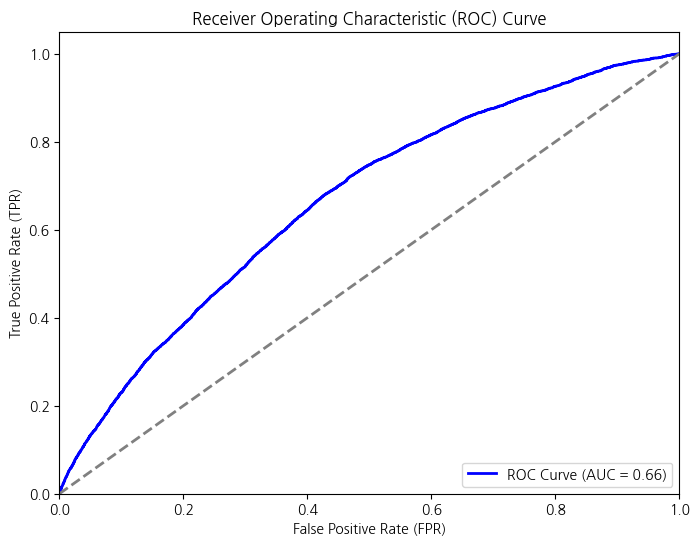

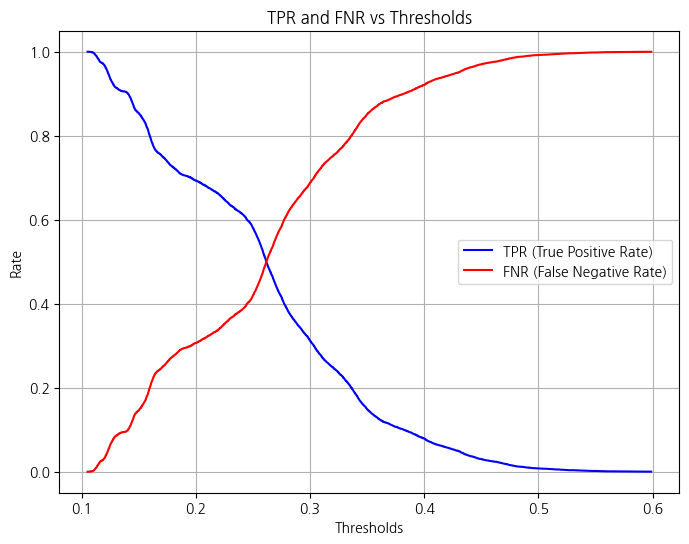

In [192]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_final)
roc_auc = auc(fpr, tpr)

# Visualize ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot TPR and FNR
fnr = 1 - tpr  # FNR = 1 - TPR

plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, color='blue', label='TPR (True Positive Rate)')
plt.plot(thresholds, fnr, color='red', label='FNR (False Negative Rate)')
plt.xlabel('Thresholds')
plt.ylabel('Rate')
plt.title('TPR and FNR vs Thresholds')
plt.legend(loc='best')
plt.grid(True)
plt.show()